### Importing Libraries

In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import PIL
from PIL import Image,ImageOps
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics import JaccardIndex
import datasets_segmentation as dataset


%load_ext autoreload
%autoreload 2

### Loading model and dataloaders

In [2]:
train_size = 100
use_augmentation = False
augmentation_type = "no"
augmentation_size = 50
augmentation_dir = ""
model_path = f"model_{augmentation_type}_aug_{augmentation_size}_train_{train_size}.pt"

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

images_dir = "../../data/unet_shenken_data/"
# get datasets
train_set = dataset.get_train_data(images_dir,
                                   train_size = train_size,
                                   use_augmentation = use_augmentation,
                                   augmentation_type = augmentation_type,
                                   augmentation_size = augmentation_size,
                                   augmentation_dir = augmentation_dir)
val_set = dataset.get_val_data(images_dir)
test_set = dataset.get_test_data(images_dir)

# setup dataloaders
batch_size = 8
train_dataloader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_set, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_set, batch_size = 1, shuffle = True)

In [4]:
#Loading Model
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=1, out_channels=1, init_features=32, pretrained=False)
model = model.to(device)

#Hyperparamaters
num_epochs = 100
val_check = 5
lr = 0.0002
beta1 = 0.5
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
criterion = nn.BCELoss()
jaccard = JaccardIndex(task = 'binary', num_classes=2)

Using cache found in /home/rmpatil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


### Dice Coefficient

In [5]:
#Dice Coefficient
def dice_coeff(pred, target):
    smooth = 1.
    pred = torch.where(pred>=0.5, 1, 0)
    iflat = pred.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

### Visualizing model outputs

In [6]:
#Function for visualization
def visualize(data,pred,label):
    batchsize = data.size()[0]
    fig, axs = plt.subplots(batchsize,3,figsize=(10,10))
    for i in range(batchsize):        
        img_plot = data[i].permute(1,2,0).detach().cpu()
        pred_plot = pred[i].permute(1,2,0).detach().cpu()
        label_plot = label[i].permute(1,2,0).detach().cpu()
        
        axs[i,0].imshow(img_plot)
        axs[i,0].set_title('Image')
        
        axs[i,1].imshow(pred_plot,cmap='gray')
        axs[i,1].set_title('Prediction')
        
        axs[i,2].imshow(label_plot,cmap='gray')
        axs[i,2].set_title('Label')
        
    plt.show()

### Validation and Test Loops

In [7]:
#Validation Loop
def validation(model,dataloader):
    losses = []
    model.eval()
    for i, (data, targets) in enumerate(dataloader, 0):
        data = data.to(device)
        targets = targets.to(device)

        pred = model(data)
        loss = criterion(pred,targets)
        losses.append(loss.item())
    return np.mean(losses)

#Test Loop
def test(model_path, dataloader):
    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=1, out_channels=1, init_features=32, pretrained=False)
    weights = torch.load(model_path)
    model.load_state_dict(weights)
    model = model.to(device)
    dice_scores = []
    model.eval()
    with torch.no_grad():
        for i, (data, targets) in enumerate(dataloader, 0):
            data = data.to(device)
            targets = targets.type(torch.int8).to(device)

            pred = model(data)
            dice_scores.append(jaccard(pred.cpu(), targets.cpu()))
    return np.mean(dice_scores)

### Training

In [ ]:
def train(model, train_dataloader, val_dataloader, model_path)
    best_loss = np.inf

    print(f"Training for model {model_path}")
    # For each epoch
    for epoch in tqdm(range(num_epochs)):
        losses = []

        # For each batch in the dataloader
        for data, targets in train_dataloader:

            data = data.to(device)
            targets = targets.to(device).to(torch.float32)
            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred,targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        print("[TRAIN] Epoch : %d, Loss : %2.5f" % (epoch, np.mean(losses)))

        if (epoch + 1) % val_check == 0:
            visualize(data[0:3],pred[0:3],targets[0:3])

            cur_loss = validation(model, val_dataloader)
            print("[VALIDATION] Epoch : %d, Loss : %2.5f" % (epoch, cur_loss))
            if cur_loss < best_loss:
                best_loss = cur_loss
                torch.save(model.state_dict(), os.path.join("seg", model_path))  

Starting Training Loop...


  0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  1%|          | 1/100 [00:12<20:13, 12.26s/it]

[TRAIN] Epoch : 0, Loss : 0.54548


  2%|▏         | 2/100 [00:24<20:13, 12.38s/it]

[TRAIN] Epoch : 1, Loss : 0.37729


  3%|▎         | 3/100 [00:37<20:10, 12.48s/it]

[TRAIN] Epoch : 2, Loss : 0.34267


  4%|▍         | 4/100 [00:49<19:45, 12.35s/it]

[TRAIN] Epoch : 3, Loss : 0.32830
[TRAIN] Epoch : 4, Loss : 0.31075


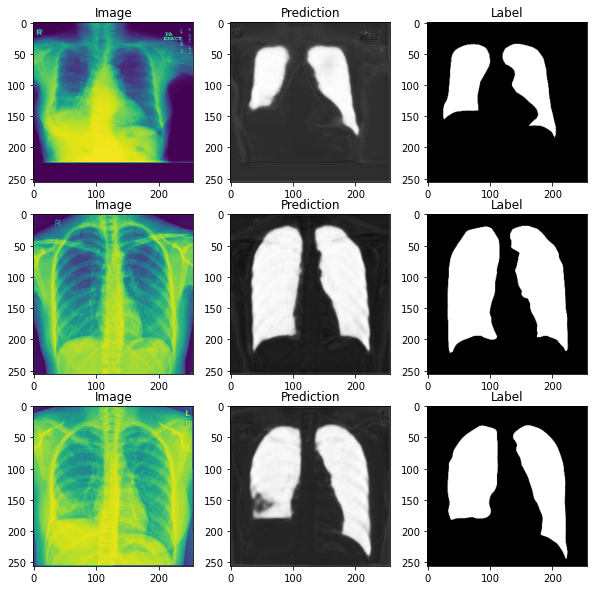

  5%|▌         | 5/100 [01:17<28:27, 17.97s/it]

[VALIDATION] Epoch : 4, Loss : 0.28934


  6%|▌         | 6/100 [01:29<25:13, 16.10s/it]

[TRAIN] Epoch : 5, Loss : 5.84441


  7%|▋         | 7/100 [01:42<23:01, 14.86s/it]

[TRAIN] Epoch : 6, Loss : 0.38630


  8%|▊         | 8/100 [01:54<21:32, 14.05s/it]

[TRAIN] Epoch : 7, Loss : 0.42184


  9%|▉         | 9/100 [02:07<20:43, 13.66s/it]

[TRAIN] Epoch : 8, Loss : 0.36875
[TRAIN] Epoch : 9, Loss : 0.35496


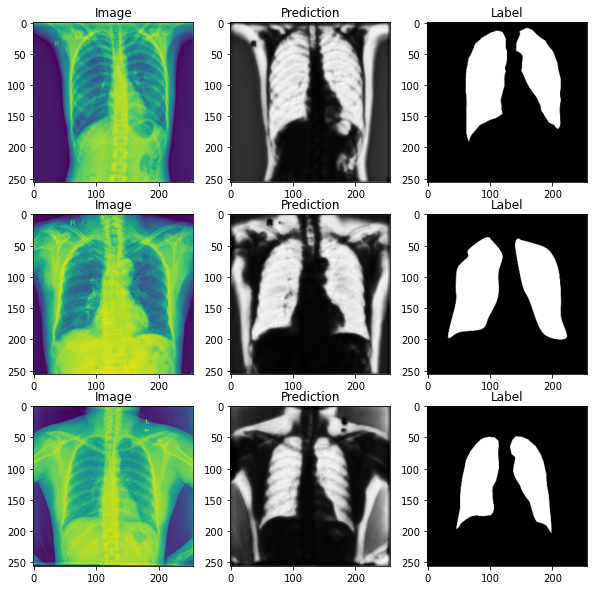

 10%|█         | 10/100 [02:34<26:51, 17.90s/it]

[VALIDATION] Epoch : 9, Loss : 0.34158


 11%|█         | 11/100 [02:47<24:06, 16.25s/it]

[TRAIN] Epoch : 10, Loss : 0.32582


 12%|█▏        | 12/100 [02:59<21:58, 14.99s/it]

[TRAIN] Epoch : 11, Loss : 0.29548


 13%|█▎        | 13/100 [03:12<20:46, 14.32s/it]

[TRAIN] Epoch : 12, Loss : 0.26784


 14%|█▍        | 14/100 [03:24<19:41, 13.74s/it]

[TRAIN] Epoch : 13, Loss : 0.17185
[TRAIN] Epoch : 14, Loss : 0.13190


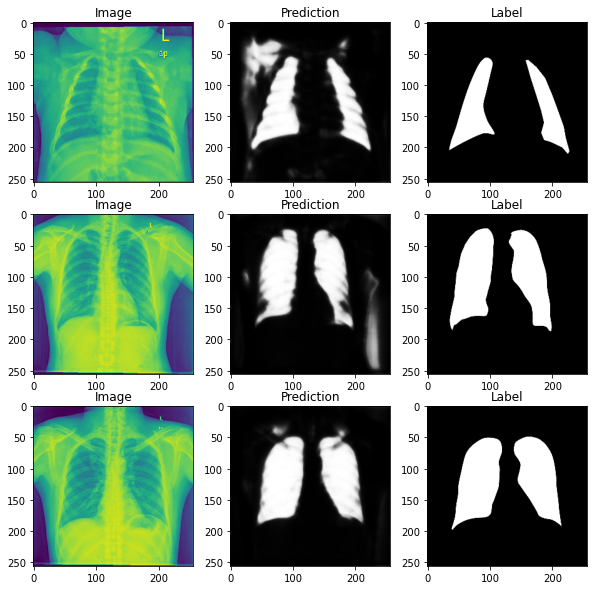

 15%|█▌        | 15/100 [03:50<24:52, 17.56s/it]

[VALIDATION] Epoch : 14, Loss : 0.11229


 16%|█▌        | 16/100 [04:02<22:14, 15.89s/it]

[TRAIN] Epoch : 15, Loss : 0.12238


 17%|█▋        | 17/100 [04:15<20:41, 14.96s/it]

[TRAIN] Epoch : 16, Loss : 0.08885


 18%|█▊        | 18/100 [04:28<19:30, 14.28s/it]

[TRAIN] Epoch : 17, Loss : 0.07953


 19%|█▉        | 19/100 [04:40<18:30, 13.71s/it]

[TRAIN] Epoch : 18, Loss : 0.07521
[TRAIN] Epoch : 19, Loss : 0.06567


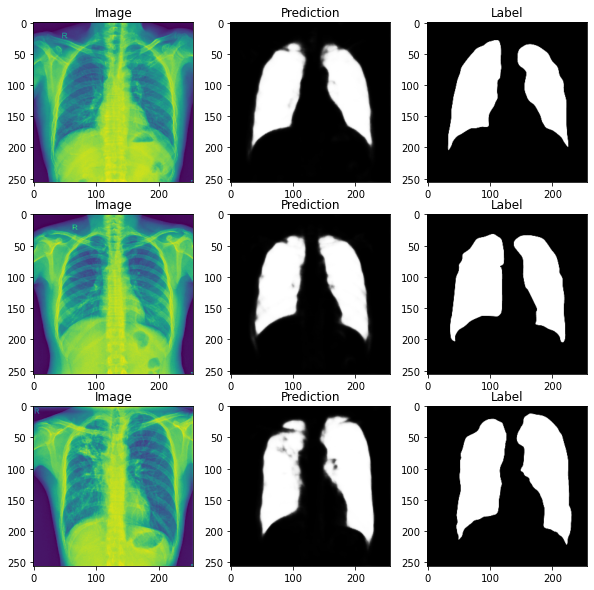

 20%|██        | 20/100 [05:07<23:26, 17.58s/it]

[VALIDATION] Epoch : 19, Loss : 0.07219


 21%|██        | 21/100 [05:19<21:01, 15.97s/it]

[TRAIN] Epoch : 20, Loss : 0.06087


 22%|██▏       | 22/100 [05:32<19:26, 14.96s/it]

[TRAIN] Epoch : 21, Loss : 0.06122


 23%|██▎       | 23/100 [05:44<18:19, 14.28s/it]

[TRAIN] Epoch : 22, Loss : 0.05695


 24%|██▍       | 24/100 [05:57<17:22, 13.72s/it]

[TRAIN] Epoch : 23, Loss : 0.05910
[TRAIN] Epoch : 24, Loss : 0.05315


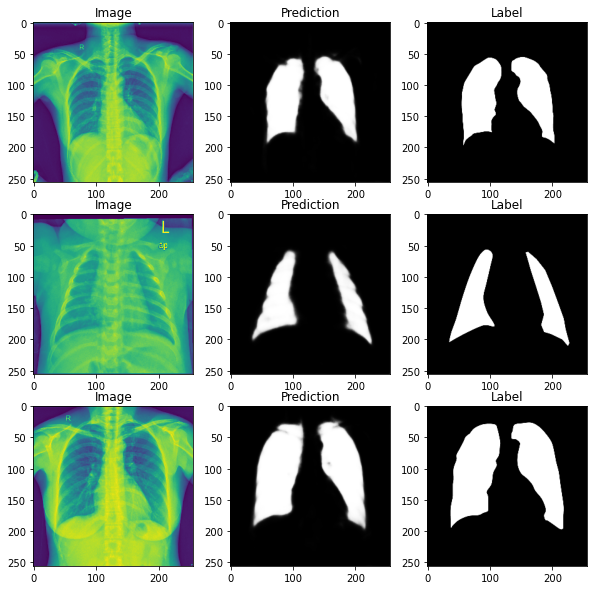

 25%|██▌       | 25/100 [06:24<22:00, 17.61s/it]

[VALIDATION] Epoch : 24, Loss : 0.06209


 26%|██▌       | 26/100 [06:36<19:47, 16.05s/it]

[TRAIN] Epoch : 25, Loss : 0.05313


 27%|██▋       | 27/100 [06:49<18:24, 15.13s/it]

[TRAIN] Epoch : 26, Loss : 0.05208


 28%|██▊       | 28/100 [07:02<17:29, 14.58s/it]

[TRAIN] Epoch : 27, Loss : 0.05018


 29%|██▉       | 29/100 [07:15<16:29, 13.93s/it]

[TRAIN] Epoch : 28, Loss : 0.64221
[TRAIN] Epoch : 29, Loss : 0.33846


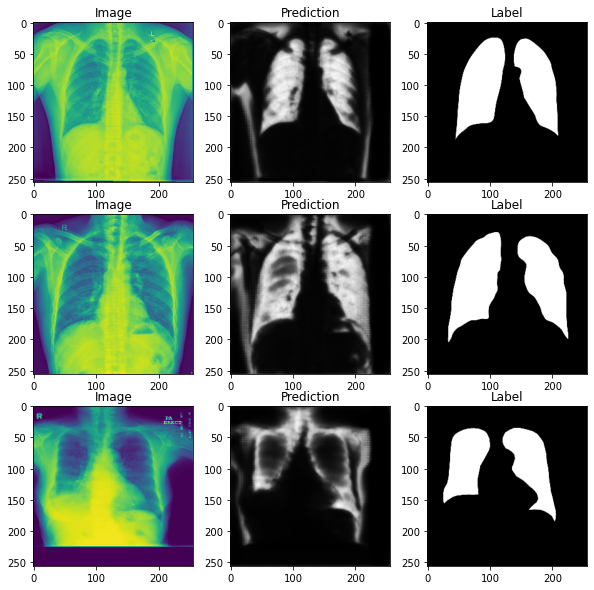

 30%|███       | 30/100 [07:41<20:38, 17.70s/it]

[VALIDATION] Epoch : 29, Loss : 0.32267


 31%|███       | 31/100 [07:54<18:46, 16.32s/it]

[TRAIN] Epoch : 30, Loss : 0.26327


 32%|███▏      | 32/100 [08:07<17:18, 15.27s/it]

[TRAIN] Epoch : 31, Loss : 0.20521


 33%|███▎      | 33/100 [08:20<16:08, 14.46s/it]

[TRAIN] Epoch : 32, Loss : 0.15513


 34%|███▍      | 34/100 [08:32<15:21, 13.97s/it]

[TRAIN] Epoch : 33, Loss : 0.12833
[TRAIN] Epoch : 34, Loss : 0.09921


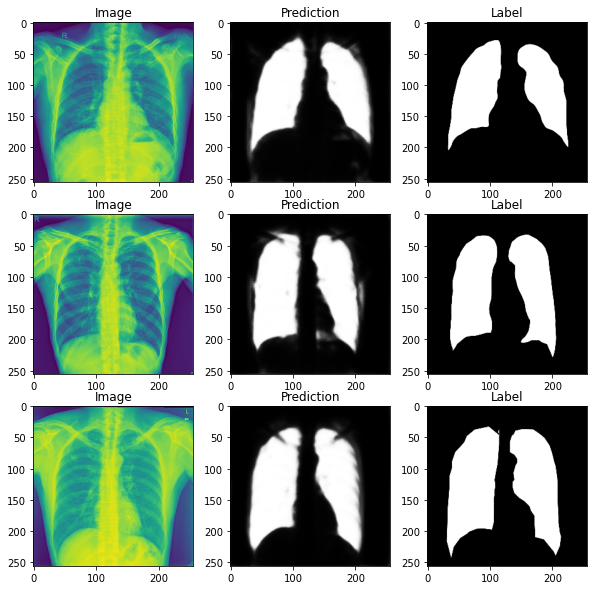

 35%|███▌      | 35/100 [08:59<19:09, 17.69s/it]

[VALIDATION] Epoch : 34, Loss : 0.08910


 36%|███▌      | 36/100 [09:12<17:16, 16.20s/it]

[TRAIN] Epoch : 35, Loss : 0.07865


 37%|███▋      | 37/100 [09:24<15:48, 15.06s/it]

[TRAIN] Epoch : 36, Loss : 0.07007


 38%|███▊      | 38/100 [09:37<14:51, 14.38s/it]

[TRAIN] Epoch : 37, Loss : 0.06332


 39%|███▉      | 39/100 [09:49<13:59, 13.76s/it]

[TRAIN] Epoch : 38, Loss : 0.06523
[TRAIN] Epoch : 39, Loss : 0.05815


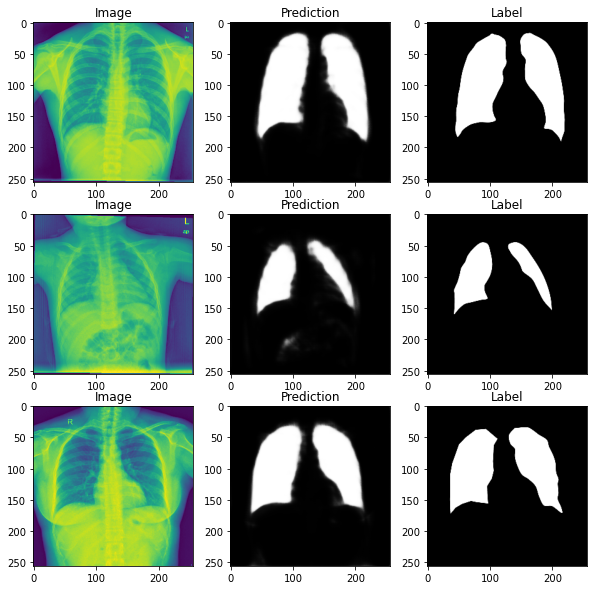

 40%|████      | 40/100 [10:16<17:39, 17.66s/it]

[VALIDATION] Epoch : 39, Loss : 0.06356


 41%|████      | 41/100 [10:29<16:01, 16.30s/it]

[TRAIN] Epoch : 40, Loss : 0.05558


 42%|████▏     | 42/100 [10:42<14:49, 15.33s/it]

[TRAIN] Epoch : 41, Loss : 0.06050


 43%|████▎     | 43/100 [10:54<13:37, 14.34s/it]

[TRAIN] Epoch : 42, Loss : 0.05625


 44%|████▍     | 44/100 [11:07<12:53, 13.82s/it]

[TRAIN] Epoch : 43, Loss : 0.05169
[TRAIN] Epoch : 44, Loss : 0.05059


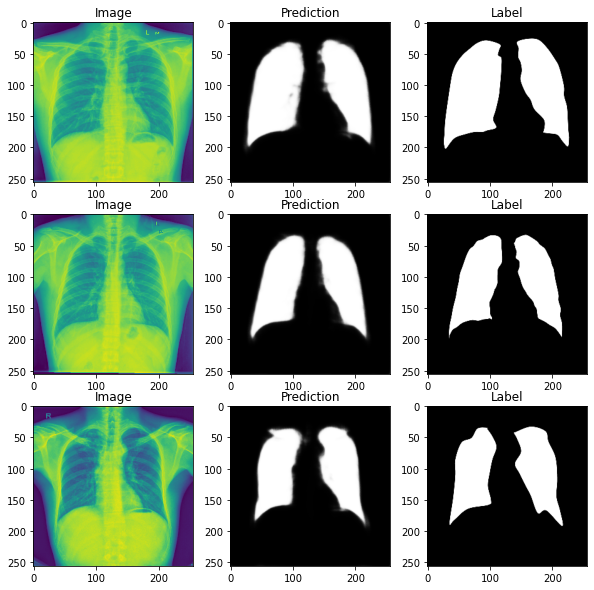

 45%|████▌     | 45/100 [11:34<16:16, 17.75s/it]

[VALIDATION] Epoch : 44, Loss : 0.05950


 46%|████▌     | 46/100 [11:46<14:33, 16.17s/it]

[TRAIN] Epoch : 45, Loss : 0.04772


 47%|████▋     | 47/100 [11:59<13:19, 15.09s/it]

[TRAIN] Epoch : 46, Loss : 0.05007


 48%|████▊     | 48/100 [12:11<12:23, 14.29s/it]

[TRAIN] Epoch : 47, Loss : 0.04693


 49%|████▉     | 49/100 [12:24<11:47, 13.87s/it]

[TRAIN] Epoch : 48, Loss : 0.04866
[TRAIN] Epoch : 49, Loss : 0.04779


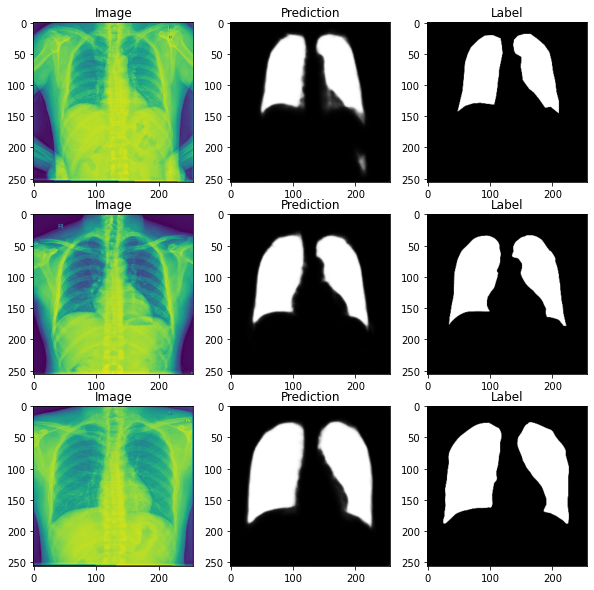

 50%|█████     | 50/100 [12:51<14:48, 17.78s/it]

[VALIDATION] Epoch : 49, Loss : 0.06268


 51%|█████     | 51/100 [13:04<13:18, 16.29s/it]

[TRAIN] Epoch : 50, Loss : 0.04482


 52%|█████▏    | 52/100 [13:16<12:04, 15.09s/it]

[TRAIN] Epoch : 51, Loss : 0.04615


 53%|█████▎    | 53/100 [13:28<11:12, 14.31s/it]

[TRAIN] Epoch : 52, Loss : 0.04600


 54%|█████▍    | 54/100 [13:41<10:36, 13.83s/it]

[TRAIN] Epoch : 53, Loss : 0.04421
[TRAIN] Epoch : 54, Loss : 0.04394


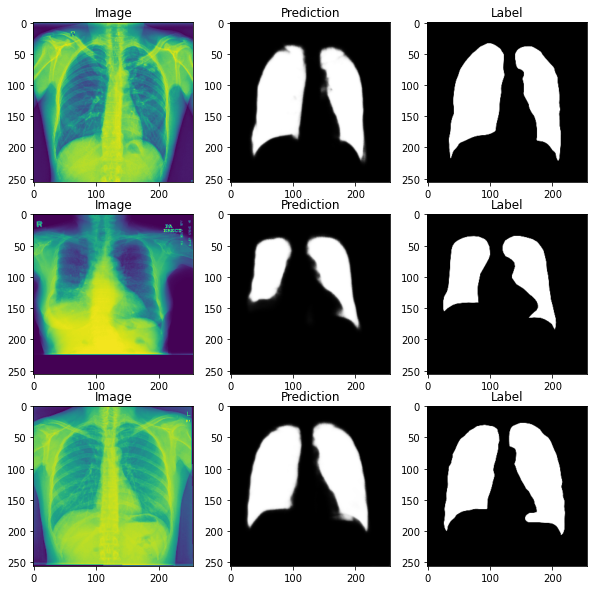

 55%|█████▌    | 55/100 [14:08<13:17, 17.71s/it]

[VALIDATION] Epoch : 54, Loss : 0.06988


 56%|█████▌    | 56/100 [14:20<11:51, 16.16s/it]

[TRAIN] Epoch : 55, Loss : 0.04205


 57%|█████▋    | 57/100 [14:33<10:47, 15.06s/it]

[TRAIN] Epoch : 56, Loss : 0.03982


 58%|█████▊    | 58/100 [14:45<09:56, 14.20s/it]

[TRAIN] Epoch : 57, Loss : 0.04123


 59%|█████▉    | 59/100 [14:58<09:20, 13.66s/it]

[TRAIN] Epoch : 58, Loss : 0.03968
[TRAIN] Epoch : 59, Loss : 0.03827


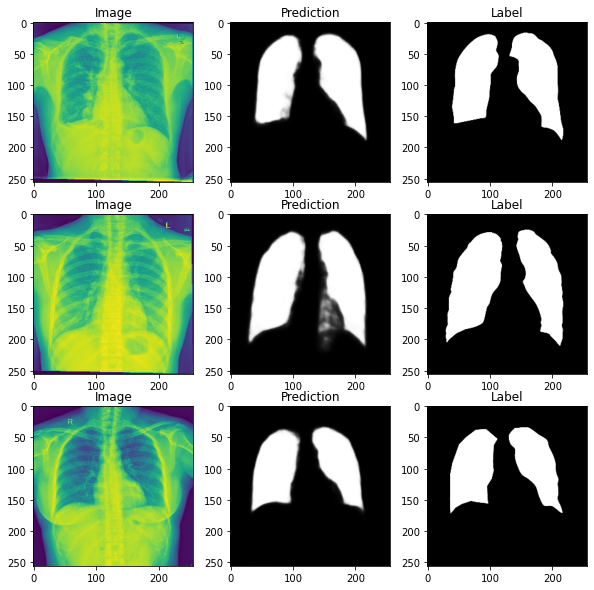

 60%|██████    | 60/100 [15:24<11:46, 17.65s/it]

[VALIDATION] Epoch : 59, Loss : 0.05947


 61%|██████    | 61/100 [15:37<10:30, 16.18s/it]

[TRAIN] Epoch : 60, Loss : 0.03854


 62%|██████▏   | 62/100 [15:51<09:48, 15.49s/it]

[TRAIN] Epoch : 61, Loss : 0.03849


 63%|██████▎   | 63/100 [16:04<09:03, 14.68s/it]

[TRAIN] Epoch : 62, Loss : 0.03597


 64%|██████▍   | 64/100 [16:17<08:28, 14.13s/it]

[TRAIN] Epoch : 63, Loss : 0.03561
[TRAIN] Epoch : 64, Loss : 0.03374


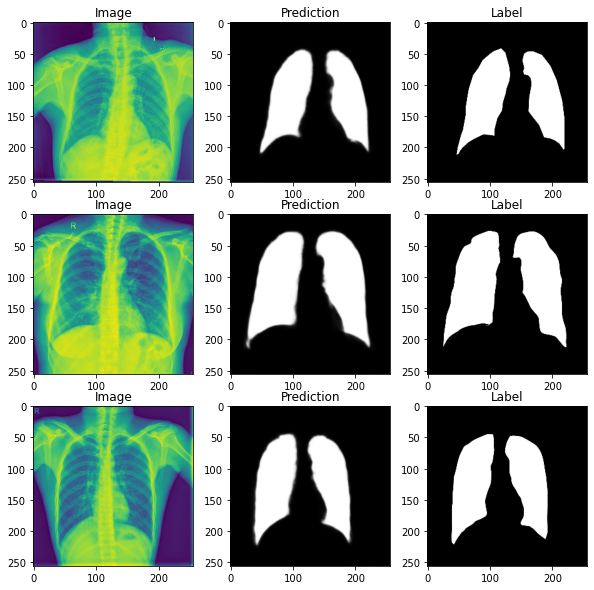

 65%|██████▌   | 65/100 [16:44<10:29, 17.98s/it]

[VALIDATION] Epoch : 64, Loss : 0.06377


 66%|██████▌   | 66/100 [16:56<09:16, 16.36s/it]

[TRAIN] Epoch : 65, Loss : 0.03476


 67%|██████▋   | 67/100 [17:09<08:20, 15.15s/it]

[TRAIN] Epoch : 66, Loss : 0.03591


 68%|██████▊   | 68/100 [17:21<07:40, 14.38s/it]

[TRAIN] Epoch : 67, Loss : 0.03396


 69%|██████▉   | 69/100 [17:34<07:07, 13.79s/it]

[TRAIN] Epoch : 68, Loss : 0.03396
[TRAIN] Epoch : 69, Loss : 0.03445


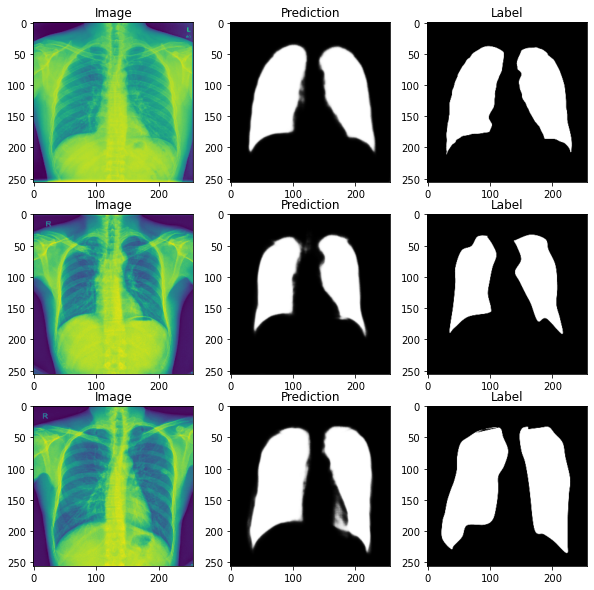

 70%|███████   | 70/100 [18:00<08:49, 17.66s/it]

[VALIDATION] Epoch : 69, Loss : 0.06733


 71%|███████   | 71/100 [18:14<07:55, 16.39s/it]

[TRAIN] Epoch : 70, Loss : 0.03395


 72%|███████▏  | 72/100 [18:27<07:15, 15.55s/it]

[TRAIN] Epoch : 71, Loss : 0.03286


 73%|███████▎  | 73/100 [18:41<06:40, 14.85s/it]

[TRAIN] Epoch : 72, Loss : 0.04299


 74%|███████▍  | 74/100 [18:53<06:10, 14.26s/it]

[TRAIN] Epoch : 73, Loss : 0.04497
[TRAIN] Epoch : 74, Loss : 0.06718


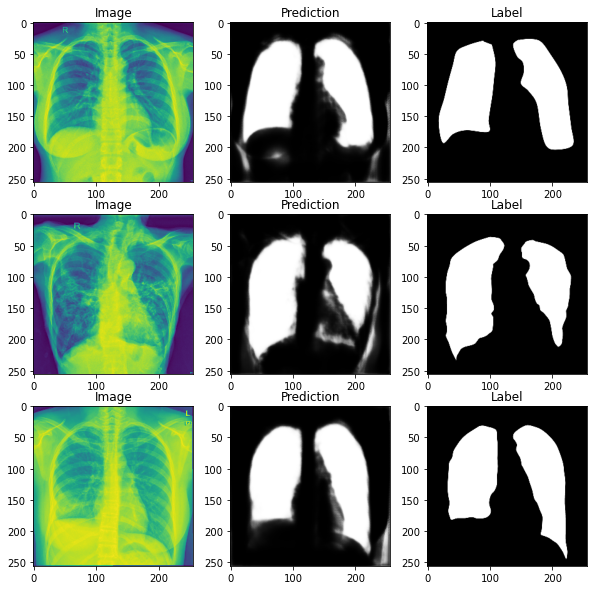

 75%|███████▌  | 75/100 [19:26<08:16, 19.84s/it]

[VALIDATION] Epoch : 74, Loss : 0.07711


 76%|███████▌  | 76/100 [19:45<07:46, 19.42s/it]

[TRAIN] Epoch : 75, Loss : 0.04994


 77%|███████▋  | 77/100 [20:04<07:23, 19.27s/it]

[TRAIN] Epoch : 76, Loss : 0.04478


 78%|███████▊  | 78/100 [20:23<07:06, 19.37s/it]

[TRAIN] Epoch : 77, Loss : 0.04013


 79%|███████▉  | 79/100 [20:42<06:41, 19.14s/it]

[TRAIN] Epoch : 78, Loss : 0.03478
[TRAIN] Epoch : 79, Loss : 0.03325


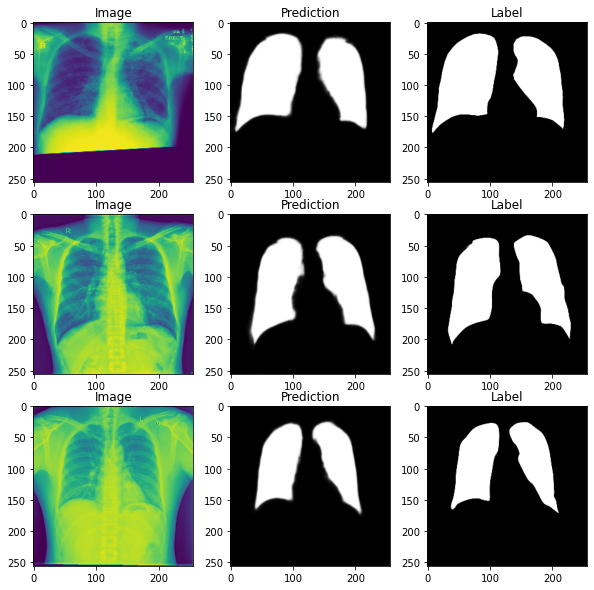

 80%|████████  | 80/100 [21:27<08:57, 26.88s/it]

[VALIDATION] Epoch : 79, Loss : 0.06499


 81%|████████  | 81/100 [21:48<07:57, 25.13s/it]

[TRAIN] Epoch : 80, Loss : 0.03247


 82%|████████▏ | 82/100 [22:07<06:58, 23.26s/it]

[TRAIN] Epoch : 81, Loss : 0.03030


 83%|████████▎ | 83/100 [22:27<06:18, 22.28s/it]

[TRAIN] Epoch : 82, Loss : 0.03164


 84%|████████▍ | 84/100 [22:47<05:47, 21.72s/it]

[TRAIN] Epoch : 83, Loss : 0.02905
[TRAIN] Epoch : 84, Loss : 0.02844


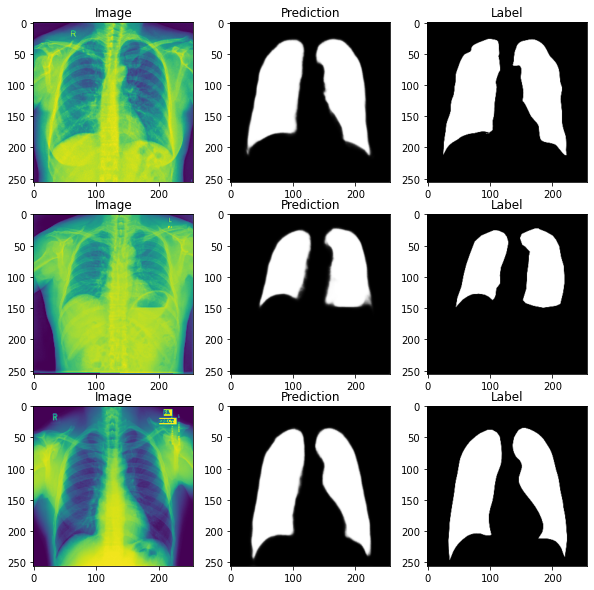

 85%|████████▌ | 85/100 [23:29<06:56, 27.74s/it]

[VALIDATION] Epoch : 84, Loss : 0.08066


 86%|████████▌ | 86/100 [23:46<05:42, 24.45s/it]

[TRAIN] Epoch : 85, Loss : 0.02810


 87%|████████▋ | 87/100 [23:59<04:34, 21.08s/it]

[TRAIN] Epoch : 86, Loss : 0.03752


 88%|████████▊ | 88/100 [24:12<03:43, 18.62s/it]

[TRAIN] Epoch : 87, Loss : 0.02976


 88%|████████▊ | 88/100 [24:17<03:18, 16.56s/it]


KeyboardInterrupt: 

In [8]:
train(model, train_dataloader, val_dataloader, model_path)

### Test acccuracy of all the models

In [ ]:
model_names = sorted([i for i in os.listdir('seg') if i.endswith('.pt')])
for model in model_names:
    test_accuracy = test(os.path.join('seg/', model), test_dataloader)
    print(model, test_accuracy)

### Results - Dice Scores



|Train Size| Without Augmentation | Baseline Augmentation| With Augmentation |
| :-: | :-: |:-: | :-: |
| 0   | -       | 0.794 | 0.826 |
| 20  | 0.863  | 0.907 | 0.922  |
| 50  | 0.904  | 0.938 | 0.931 |
| 100 | 0.935 | 0.940 | 0.948 |
| 200 | 0.946 | 0.948 | 0.950 |